In [4]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [6]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<h2>Replay Buffer</h2>

In [7]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Cart Pole Environment</h2>

In [8]:
env_id = "CartPole-v0"
env = gym.make(env_id)

<h2>Epsilon greedy exploration</h2>

In [9]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

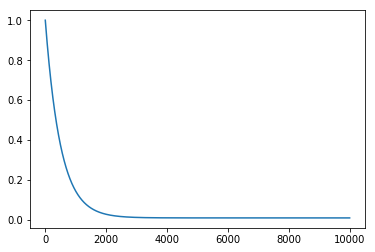

In [10]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

<h2>Double Deep Q Network</h2>

In [11]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        with torch.no_grad():
            if random.random() > epsilon:
                state   = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
                q_value = self.forward(state)
                action  = q_value.max(1)[1].item()
            else:
                action = random.randrange(env.action_space.n)
        return action

In [12]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
    
optimizer = optim.Adam(current_model.parameters())

replay_buffer = ReplayBuffer(1000)

<h3>Synchronize current policy net and target net</h3>

In [13]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [14]:
update_target(current_model, target_model)

<h2>Computing Temporal Difference Loss</h2>

In [15]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(DEVICE)
    next_state = torch.FloatTensor(next_state).to(DEVICE)
    action     = torch.LongTensor(action).to(DEVICE)
    reward     = torch.FloatTensor(reward).to(DEVICE)
    done       = torch.FloatTensor(done).to(DEVICE)

    q_values      = current_model(state)
    next_q_values = current_model(next_state)  # 由当前网络算出下一个状态的Q值
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1)  # 选取action对应的Q值
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1) # 选取最大的Q值
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [16]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame {:5d} reward: {:.2f}'.format(frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2>Training</h2>

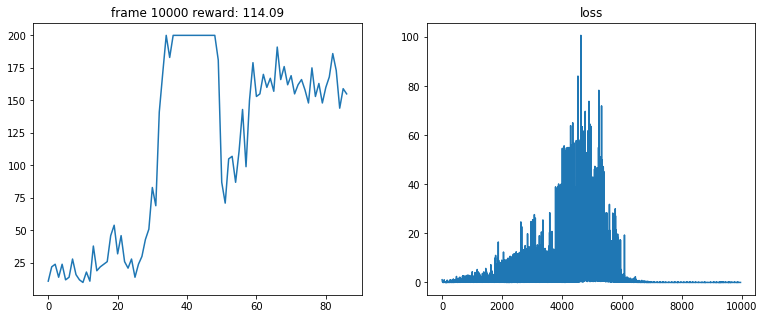

In [17]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model, target_model)
        

<p><hr></p>

<h1>Atari Environment</h1>

In [18]:
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [19]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [20]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        with torch.no_grad():
            if random.random() > epsilon:
                state   = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(DEVICE)
                q_value = self.forward(state)
                action  = q_value.max(1)[1].item()
            else:
                action = random.randrange(env.action_space.n)
            return action

In [21]:
current_model = CnnDQN(env.observation_space.shape, env.action_space.n).to(DEVICE)
target_model  = CnnDQN(env.observation_space.shape, env.action_space.n).to(DEVICE)

optimizer = optim.Adam(current_model.parameters(), lr=0.0001)
replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

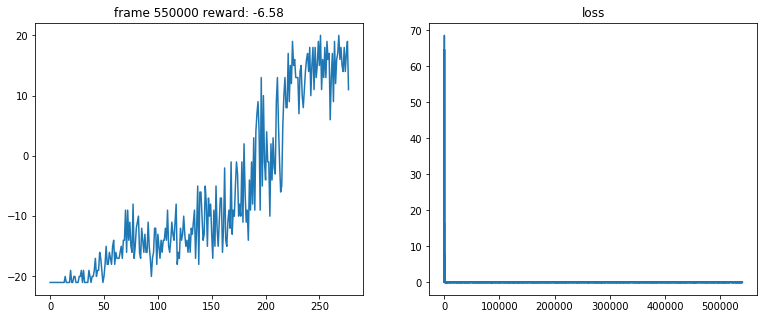

In [ ]:
num_frames = 1000000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)